In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('spam.csv' , encoding='latin1')
df.head()
df.info()
        #DATA CLEANING
#drop last 3 col
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df.info()

#renaming column
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

#char -> number using label encoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
df.head()

#check for missing values
df.isnull().sum()

#check fo rduplicate values
df.duplicated().sum()
df = df.drop_duplicates(keep='first')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [2]:
df.shape

(5169, 2)

2. EDA - exploratory data analysis
check how much %is spam and ham
ham -> 0 , spam -> 1


In [3]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

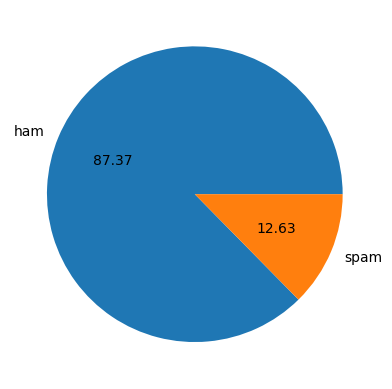

In [4]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct="%0.2f")
plt.show()

what we analysed?
1. calculated % of ham and spam-> ham >>> spam. data is imbalanced

next we make 3 columns(3 new features)
c1 -> no. of char
c2 -> no. of words
c3 -> no. of sentences. 
for that we need nltk lib

In [30]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [6]:
#num of chars
df['num_char'] = df['text'].apply(len)
df.head()

#num of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

#num of sentences
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

#describe is used to see mean,std,count
df[['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


lets analyse the columns of ham and spam separately

In [7]:
#for ham msgs (target = 0(ham))
df[df['target'] == 0][['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [8]:
#target = 1(spam)
df[df['target'] == 1][['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


clearly, if we see mean of both ham and spam. spam msgs are longer than ham
spam has 137 char per sentences and ham-> 70 char per sentence

In [9]:
#plot histogram
import seaborn as sns

<Axes: xlabel='num_char', ylabel='Count'>

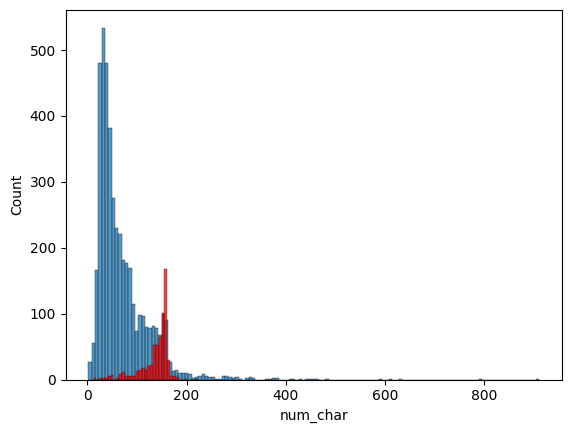

In [10]:
sns.histplot(df[df['target'] == 0]['num_char'])
sns.histplot(df[df['target'] == 1]['num_char'],color='red')

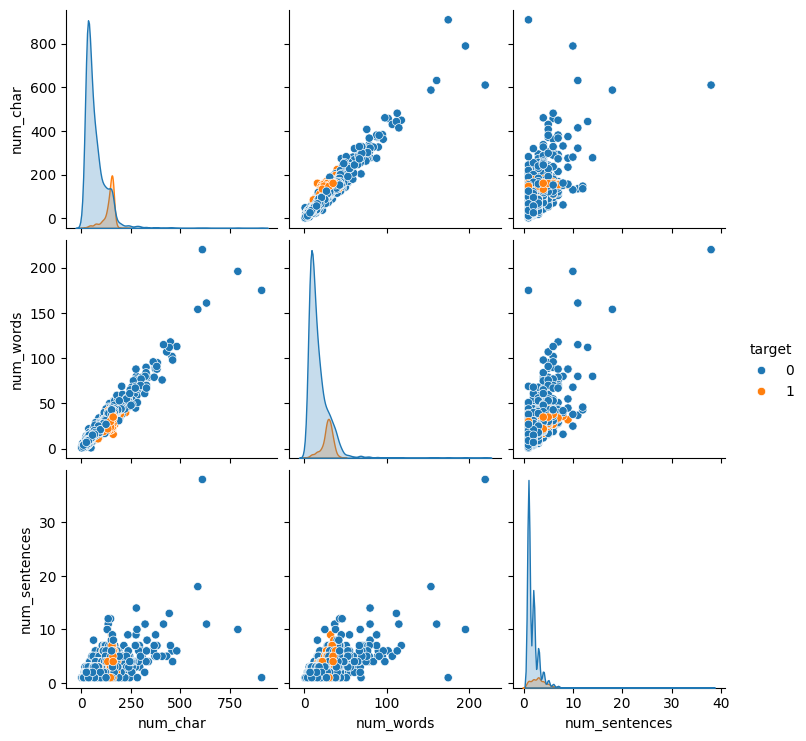

In [11]:
sns.pairplot(df,hue='target')

there are visible outliers, which can hamper model

<Axes: >

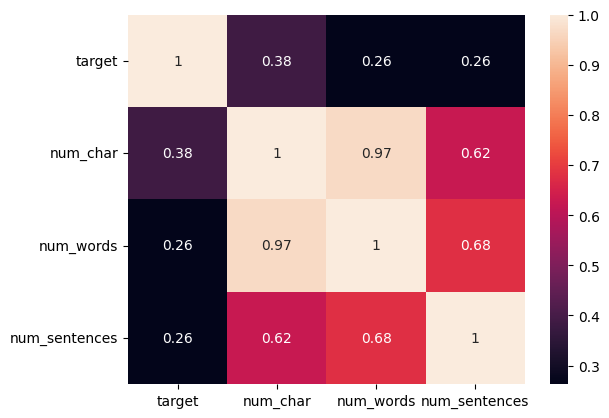

In [12]:
sns.heatmap(df.select_dtypes(include='number').corr(),annot=True)

heatmap tells us how to decide which numeric text-based feature is best for spam detection.
target vs num_char = 0.38  (strongest). -> Messages with more characters are more likely to be spam(target = 1).
Which feature should you choose? ->num_char as it has Highest correlation with target

3. data preprocessing
lower case, tokenization, removing special char, removing stop words(ex-> is, of, the,by) and punctuation, stemming(convert same tpe of word into single word ex-> dance, dancing, dances to 'dance')

create a nw single func to perform all these step 

In [ ]:

from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
#example what stem do
ps.stem('dancing')



In [45]:
def transform_text(text):
    #1. converted to lower
    text = text.lower()

    #2. tokenize the words and return list
    text = nltk.word_tokenize(text) 
    # we can run a loop on list to remove special char

    #3. removed special char
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    #4. removed stopwords and punctuation
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    #5. stemming
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    return " ".join(y)
    

In [47]:
# 1st mail
df['text'][0] 

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [50]:
transform_text('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

In [52]:
df['transformed_text'] = df['text'].apply(transform_text)

In [53]:
df.head()

,target,text,num_char,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


now generate the word cloud model 

In [61]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10,background_color = 'white')

In [63]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

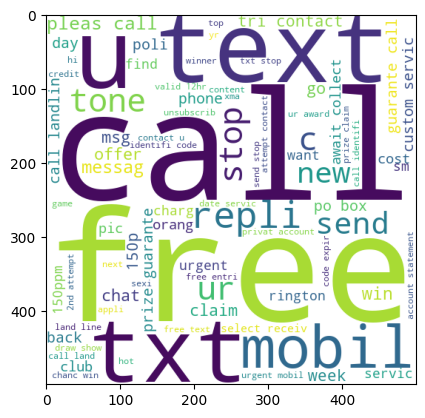

In [64]:
plt.imshow(spam_wc)

In [65]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

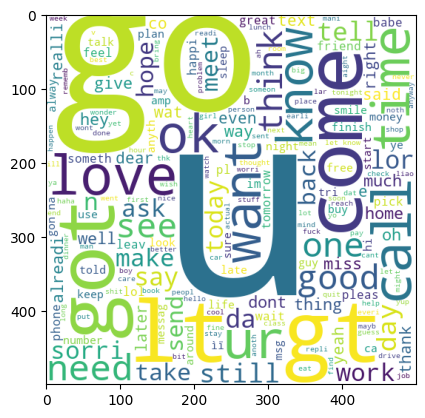

In [66]:
plt.imshow(ham_wc)

now lets find out what are the top 30 most used words

In [68]:
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    print(msg)

free entri 2 wkli comp win fa cup final tkt 21st may text fa 87121 receiv entri question std txt rate c appli 08452810075over18
freemsg hey darl 3 week word back like fun still tb ok xxx std chg send rcv
winner valu network custom select receivea prize reward claim call claim code kl341 valid 12 hour
mobil 11 month u r entitl updat latest colour mobil camera free call mobil updat co free 08002986030
six chanc win cash 100 pound txt csh11 send cost 6day tsandc appli repli hl 4 info
urgent 1 week free membership prize jackpot txt word claim 81010 c lccltd pobox 4403ldnw1a7rw18
xxxmobilemovieclub use credit click wap link next txt messag click http
england v macedonia dont miss news txt ur nation team 87077 eg england 87077 tri wale scotland poboxox36504w45wq
thank subscript rington uk mobil charg pleas confirm repli ye repli charg
07732584351 rodger burn msg tri call repli sm free nokia mobil free camcord pleas call 08000930705 deliveri tomorrow
sm ac sptv new jersey devil detroit red wi